用标注好的搜狗新闻语料，基于scikit-learn

# 1. 语料预处理

In [24]:
import os
import shutil
import re
import jieba

import numpy as np 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

定义搜狗新闻文本标签的名称，类似C000008这样的标签是语料的子目录，在网上搜到标签对应的新闻类别，为了便于理解，定义了这个映射词典，并保留原有编号信息。
经济 信息技术 健康 体育 旅游 教育 招聘信息 文化 军事

In [25]:
category_labels = {
    'C000008': '_08_Finance',
    'C000010': '_10_IT',
    'C000013': '_13_Health',
    'C000014': '_14_Sports',
    'C000016': '_16_Travel',
    'C000020': '_20_Education',
    'C000022': '_22_Recruit',
    'C000023': '_23_Culture',
    'C000024': '_24_Military'
}

下面进行语料的切分，将每个类别的大约前75%作为训练语料，后25%作为测试语料。切分完之后的语料目录如下：

In [26]:
def split_corpus():
    #原始的数据文件夹
    original_dataset_dir = './CN_Corpus/SogouC.reduced/Reduced'
    base_dir = 'data/'

    if (os.path.exists(base_dir)):
        print('data文件夹已经存在.')
        return
    
    # 创建新的文件夹
    os.mkdir(base_dir)
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

    # 切分语料库
    for cate in os.listdir(original_dataset_dir):
        cate_dir = os.path.join(original_dataset_dir, cate)
        file_list = os.listdir(cate_dir)
        print("cate: {}, len: {}".format(cate, len(file_list)))

        # train数据集
        fnames = file_list[:1500] 
        dst_dir = os.path.join(train_dir, category_labels[cate])
        os.mkdir(dst_dir)
        print("dst_dir: {}, len: {}".format(dst_dir, len(fnames)))
        for fname in fnames:
            src = os.path.join(cate_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copyfile(src, dst)

        # test数据集
        fnames = file_list[1500:] 
        dst_dir = os.path.join(test_dir, category_labels[cate])
        os.mkdir(dst_dir)
        print("dst_dir: {}, len: {}".format(dst_dir, len(fnames)))
        for fname in fnames:
            src = os.path.join(cate_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copyfile(src, dst)
    print('语料切分完成。')

split_corpus()

data文件夹已经存在.


# 2. 生成训练集和测试集
## 2.1 中文分词
定义一个分词预处理函数，采用jieba分词工具，主要去掉对文本分类无用的标点符号和数字，输入为新闻文本，输出为分词之后并用空格连接的文本。

In [27]:
token = "[0-9\s+\.\!\/_,$%^*()?;；：【】+\"\'\[\]\\]+|[+——！，;:。？《》、~@#￥%……&*（）“”.=-]+"

def preprocess(text):
    text1 = re.sub('&nbsp', ' ', text)
    str_no_punctuation = re.sub(token, ' ', text1)  # 去掉标点
    text_list = list(jieba.cut(str_no_punctuation))   # 分词列表
    text_list = [item for item in text_list if item != ' '] # 去掉空格
    return ' '.join(text_list)

## 2.2 生成数据集
从上面切分好的语料目录中读取文本并进行分词预处理，输出：训练语料数据(X_train_data)、训练语料标签(y_train)、测试语料数据(X_test_data)、测试语料标签(y_test)。

In [28]:
def load_datasets():
    base_dir = 'data/'
    X_data = {'train':[], 'test':[]}
    y = {'train':[], 'test':[]}
    for type_name in ['train', 'test']:
        corpus_dir = os.path.join(base_dir, type_name)
        corpus_list = []
        for label in os.listdir(corpus_dir):
            label_dir = os.path.join(corpus_dir, label)
            file_list = os.listdir(label_dir)
            print("label: {}, len: {}".format(label, len(file_list)))

            for fname in file_list:
                file_path = os.path.join(label_dir, fname)
                with open(file_path, encoding='gb2312', errors='ignore') as text_file:
                    text_content = preprocess(text_file.read())
                X_data[type_name].append(text_content)
                y[type_name].append(label)

        print("{} corpus len: {}\n".format(type_name, len(X_data[type_name])))
    
    return X_data['train'], y['train'], X_data['test'], y['test']

X_train_data, y_train, X_test_data, y_test = load_datasets()

label: _08_Finance, len: 1500
label: _10_IT, len: 1500
label: _13_Health, len: 1500
label: _14_Sports, len: 1500
label: _16_Travel, len: 1500
label: _20_Education, len: 1500
label: _22_Recruit, len: 1500
label: _23_Culture, len: 1500
label: _24_Military, len: 1500
train corpus len: 13500

label: _08_Finance, len: 490
label: _10_IT, len: 490
label: _13_Health, len: 490
label: _14_Sports, len: 490
label: _16_Travel, len: 490
label: _20_Education, len: 490
label: _22_Recruit, len: 490
label: _23_Culture, len: 490
label: _24_Military, len: 490
test corpus len: 4410



举例：数据集的形式如下：

In [42]:
X_train_data[1024]

'本报 北京 ５ 月 ８ 日讯 记者 富子梅 报道 当前 我国 政策性 银行 改革 的 基本 方向 是 向 开发性 银行 转型 应从 我国 国情 和 三家 政策性 银行 的 具体情况 出发 有 针对性 地 设计 政策性 银行 转型 方案 对 不同 性质 的 项目 实行 分账 管理 完善 公司 治理 结构 深化 内部 改革 建立 现代 银行 制度 这是 记者 从 近日 召开 的 政策性 银行 改革 与 转型 国际 研讨会 上 获悉 的 研讨会 由 中国 金融 学会 举办 中国人民银行 行长 中国 金融 学会 会长 周小川 在 演讲 中说 １ ９ ９ ３ 年 我国 建立 政策性 银行 国家开发银行 中国进出口银行 农业发展银行 使 当时 的 四大 专业银行 摆脱 政策性 贷款 的 业务 确实 转向 商业性 银行 周小川 指出 当前 三家 政策性 银行 也 面临 着 新 的 挑战 新 的 任务 和 新 的 转型 政策性 银行 需要 进一步 考虑 自己 的 发展 方向 除了 继续 探索 在 国内 发挥作用 以外 还要 加快 融入 国际 经济'

In [43]:
y_train[1024]

'_08_Finance'

X_train_data[1024] 对应的直观的词汇的出现频率

(-0.5, 1599.5, 799.5, -0.5)

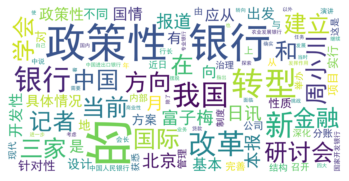

In [44]:
wordcloud = WordCloud(scale=4,
                      font_path='simhei.ttf',
                      background_color='white',
                      max_words = 100,
                      max_font_size = 60,
                      random_state=20).generate(X_train_data[1024])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

文本中的高频词信息；  频率高的词（去除停用词之后）比较能代表文本的主旨信息，后面的分类过程大概就是这个思路

# 3. 文本特征提取:TF-IDF
将文档信息，也即每篇新闻被分好词之后的词集合，转为为基于词频-你文档词频（TF-IDF）的向量，向量的每个元素都是对应于某个词在这个文档中的TF-IDF值，在不同文档中，同一词的TF-IDF是不一样的。所有文档的TF-IDF向量堆放在一起就组成了一个TF-IDF矩阵。这里应该包含了除停用词之外的所有词的TF-IDF值，词的个数构成了向量的维度。

用TfidfVectorizer将文档集合转为TF-IDF矩阵。前面将文本做了分词并用空格隔开。如果是英文，本身就是空格隔开的，而英文的分词（Tokenizing）是包含在特征提取器中的，不需要分词这一步骤。下面在得到了分类器之后，使用新文本进行分类预测时，需要先做一下中文分词。

In [45]:
stopwords = open('dict/stop_words.txt', encoding='utf-8').read().split()

# TF-IDF feature extraction
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords)  # 删除停用词
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_data)
words = tfidf_vectorizer.get_feature_names()

In [46]:
X_train_tfidf.shape

(13500, 223094)

In [47]:
len(words)

223094

# 4. 构建分类器
得到了训练样本的文本特征，现在可以训练出一个分类器，以用来对新的新闻文本进行分类。scikit-learn中提供了多种分类器

In [56]:
# SVM
text_clf_svm = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2')),    # 随机梯度下降分类器 如果loss function是hinge loss 那么就是SVM
])

In [57]:
news_lastest = ["360金融旗下产品有360借条、360小微贷、360分期。360借条是360金融的核心产品，是一款无抵押、纯线上消费信贷产品，为用户提供即时到账贷款服务（通俗可以理解为“现金贷”）用户借款主要用于消费支出。从收入构成来看，360金融主要有贷款便利服务费、贷后管理服务费、融资收入、其他服务收入等构成。财报披露，营收增长主要是由于贷款便利化服务费、贷款发放后服务费和其他与贷款发放量增加相关的服务费增加。",
                "检方并未起诉全部涉嫌贿赂的家长，但起诉名单已有超过50人，耶鲁大学、斯坦福大学等录取率极低的名校涉案也让该事件受到了几乎全球的关注，该案甚至被称作美国“史上最大招生舞弊案”。",
                "俄媒称，目前尚不清楚特朗普这一言论的指向性，因为近几日，伊朗官员们都在表达力图避免与美国发生军事冲突的意愿。5月19日早些时候，伊朗革命卫队司令侯赛因·萨拉米称，伊朗只想追求和平，但并不害怕与美国发生战争。萨拉米称，“我们（伊朗）和他们（美国）之间的区别在于，美国害怕发生战争，缺乏开战的意志。”"]
X_new_data = [preprocess(doc) for doc in news_lastest]
X_new_data

['金融 旗下 产品 有 借条 小微贷 分期 借条 是 金融 的 核心 产品 是 一款 无 抵押 纯线 上 消费信贷 产品 为 用户 提供 即时 到 账 贷款 服务 通俗 可以 理解 为 现金 贷 用户 借款 主要 用于 消费 支出 从 收入 构成 来看 金融 主要 有 贷款 便利 服务费 贷后 管理 服务费 融资 收入 其他 服务收入 等 构成 财报 披露 营收 增长 主要 是 由于 贷款 便利化 服务费 贷款 发放 后 服务费 和 其他 与 贷款 发放量 增加 相关 的 服务费 增加',
 '检方 并未 起诉 全部 涉嫌 贿赂 的 家长 但 起诉 名单 已有 超过 人 耶鲁大学 斯坦福大学 等 录取率 极低 的 名校 涉案 也 让 该 事件 受到 了 几乎 全球 的 关注 该案 甚至 被称作 美国 史上 最大 招生 舞弊案',
 '俄媒称 目前 尚 不 清楚 特朗普 这一 言论 的 指向性 因为 近几日 伊朗 官员 们 都 在 表达 力图 避免 与 美国 发生 军事冲突 的 意愿 月 日 早些时候 伊朗 革命 卫队 司令 侯赛因 · 萨拉米 称 伊朗 只想 追求 和平 但 并 不 害怕 与 美国 发生 战争 萨拉米 称 我们 伊朗 和 他们 美国 之间 的 区别 在于 美国 害怕 发生 战争 缺乏 开战 的 意志']

In [58]:
text_clf_svm.fit(X_train_data, y_train)
text_clf_svm.predict(X_new_data)

array(['_08_Finance', '_10_IT', '_24_Military'], dtype='<U13')

# 5. 用测试集评估分类器
有了分类器，以及知道了如何用分类器来对新的文本进行分类预测，那么我们可以用前面划分出来的测试集对这个分类器进行性能评估。

In [59]:
predicted_svm = text_clf_svm.predict(X_test_data)
print(classification_report(predicted_svm, y_test))

               precision    recall  f1-score   support

  _08_Finance       0.87      0.92      0.90       463
       _10_IT       0.78      0.85      0.81       449
   _13_Health       0.93      0.82      0.87       556
   _14_Sports       0.99      0.99      0.99       487
   _16_Travel       0.91      0.91      0.91       490
_20_Education       0.81      0.92      0.86       434
  _22_Recruit       0.90      0.85      0.87       517
  _23_Culture       0.85      0.83      0.84       501
 _24_Military       0.96      0.91      0.93       513

     accuracy                           0.89      4410
    macro avg       0.89      0.89      0.89      4410
 weighted avg       0.89      0.89      0.89      4410



+ precision ( 精确率)：正确预测为正的，占全部预测为正的比例。它表示的是预测为正的样本中有多少是真正的正样本
+ recall（召回率）：正确预测为正的，占全部实际为正的比例。它表示的是样本中的正例有多少被预测正确了
+ F1 score 只有当P和R都很高的时候，F1才会高，所以称为调和平均数，F1的取值范围是0到1
+ support 支持度，是指原始的真实数据中属于该类的个数
+ accuracy：它是指正确分类（不管是正确分为P还是N）的比率   accuray = （TP + TN) / (TP + FP + TN + FN ) = (TP + TN) / (P+N)
+ macro avg (宏平均值)：所有标签结果的平均值。
+ weighted avg（加权平均值）：所有标签结果的加权平均值。

混淆矩阵

In [60]:
confusion_matrix(predicted_svm, y_test)

array([[427,  10,   5,   1,   4,   3,   6,   7,   0],
       [ 24, 382,   4,   3,   8,   8,  11,   7,   2],
       [ 10,  41, 457,   0,   7,  21,  10,  10,   0],
       [  0,   1,   0, 483,   0,   2,   0,   1,   0],
       [  6,  14,   0,   0, 447,   7,   3,  12,   1],
       [  3,   7,   1,   1,   1, 398,  11,  12,   0],
       [ 12,   8,  19,   0,   4,  26, 439,   9,   0],
       [  4,  15,   4,   2,  16,  17,   9, 415,  19],
       [  4,  12,   0,   0,   3,   8,   1,  17, 468]], dtype=int64)

混淆矩阵的
每一行代表了数据的真实归属类别，每一行的数据总数表示该类别的数据实例的数目